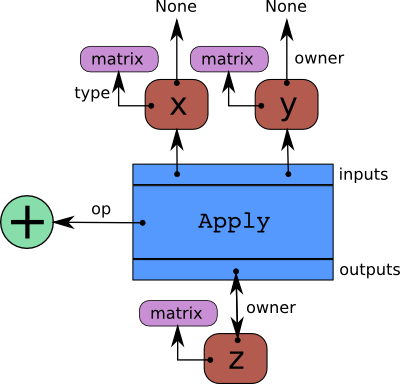

## Op’s basic methods
 - make_node() - method creates an Apply node representing the application of the Op on the inputs provided.
 - perform()   - method defines the Python implementation of an Op. 
               - It takes several arguments:
                   - node is a reference to an Apply node which was previously obtained via the make_node()
                   - inputs is a list of references to data which can be operated
                   - output_storage is a list of storage cells where the output is to be stored
                   
 - The __props__ attribute lists the properties that influence how the computation is performed
 - __props__ enables the automatic generation of appropriate __eq__() and __hash__()
 - The infer_shape() method allows an Op to infer the shape of its output variables without actually computing them.
 - The grad() method is required if you want to differentiate some cost whose expression includes your Op. 
 - The R_op() method is needed if you want aesara.gradient.Rop to work with your Op

## Example: Op definition

In [3]:
from aesara import tensor

In [1]:
import aesara
from aesara.graph.op import Op
from aesara.graph.basic import Apply


class DoubleOp1(Op):
    __props__ = ()

    def make_node(self, x):
        x = aesara.tensor.as_tensor_variable(x)
        # Note: using x_.type() is dangerous, as it copies x's broadcasting
        # behaviour
        return Apply(self, [x], [x.type()])

    def perform(self, node, inputs, output_storage):
        x = inputs[0]
        z = output_storage[0]
        z[0] = x * 2

    def infer_shape(self, fgraph, node, i0_shapes):
        return i0_shapes

    def grad(self, inputs, output_grads):
        return [output_grads[0] * 2]

    def R_op(self, inputs, eval_points):
        # R_op can receive None as eval_points.
        # That mean there is no diferientiable path through that input
        # If this imply that you cannot compute some outputs,
        # return None for those.
        if eval_points[0] is None:
            return eval_points
        return self.grad(inputs, eval_points)

doubleOp1 = DoubleOp1()


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


In [6]:
doubleOp1(tensor.vector())

DoubleOp1.0

In [9]:
import numpy as np
import aesara

x = aesara.tensor.matrix()
x

<TensorType(float64, (None, None))>

In [10]:
f = aesara.function([x], DoubleOp1()(x))

In [14]:
inp = np.arange(2*3).reshape(2,3)
inp

array([[0, 1, 2],
       [3, 4, 5]])

In [15]:
out = f(inp)
out

array([[ 0.,  2.,  4.],
       [ 6.,  8., 10.]])

In [16]:
inp = np.arange(2*3*4).reshape(2,3,4)
inp

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [17]:
out = f(inp)
out

TypeError: Bad input argument to aesara function with name "C:\Users\Purna\AppData\Local\Temp\ipykernel_6756\4237001567.py:1" at index 0 (0-based).  
Backtrace when that variable is created:

  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
    result = self._run_cell(
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
    return runner(coro)
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Purna\AppData\Local\Temp\ipykernel_6756\3645586177.py", line 4, in <cell line: 4>
    x = aesara.tensor.matrix()
Wrong number of dimensions: expected 2, got 3 with shape (2, 3, 4).

# 1. Op returns x * y

In [31]:
from aesara import tensor as at
from aesara.tensor.type import TensorType

class ProdOp(Op):
    def make_node(self, x, y):
        x = at.as_tensor_variable(x)
        y = at.as_tensor_variable(y)
        outdim = x.ndim
        output = TensorType(
            dtype=aesara.scalar.upcast(x.dtype, y.dtype), shape=[False] * outdim
        )()
        return Apply(self, inputs=[x, y], outputs=[output])

    def perform(self, node, inputs, output_storage):
        x, y = inputs
        z = output_storage[0]
        z[0] = x * y

    def infer_shape(self, fgraph, node, i0_shapes):
        return [i0_shapes[0]]

    def grad(self, inputs, output_grads):
        return [output_grads[0] * inputs[1], output_grads[0] * inputs[0]]


In [32]:
rng = np.random.default_rng(43)

In [33]:
from aesara.tensor.type import dmatrix, matrix

x = matrix()
y = matrix()

In [34]:
f = aesara.function([x, y], ProdOp()(x, y))

In [35]:
x_val = rng.random((5, 4))
y_val = rng.random((5, 4))

In [39]:
x_val.shape, y_val.shape

((5, 4), (5, 4))

In [40]:
out = f(x_val, y_val)
out

array([[3.16683821e-01, 4.13732263e-02, 1.18810339e-02, 7.91266621e-01],
       [5.85899328e-01, 7.58709442e-03, 8.91329444e-02, 2.00722194e-01],
       [5.29749506e-02, 1.54181857e-01, 2.86612802e-01, 4.91478036e-01],
       [1.41043375e-02, 1.25610718e-01, 2.34385553e-01, 4.85944625e-04],
       [1.05474324e-01, 4.80209154e-01, 2.54785008e-01, 2.23596030e-01]])

In [41]:
out.shape

(5, 4)

In [42]:
x_val = rng.random((5, 4, 3))
y_val = rng.random((5, 4, 3))

In [43]:
x_val.shape, y_val.shape

((5, 4, 3), (5, 4, 3))

In [44]:
out = f(x_val, y_val)
out

TypeError: Bad input argument to aesara function with name "C:\Users\Purna\AppData\Local\Temp\ipykernel_6756\570262654.py:1" at index 0 (0-based).  
Backtrace when that variable is created:

  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
    result = self._run_cell(
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
    return runner(coro)
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "C:\Users\Purna\anaconda3\envs\aesara-dev\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Purna\AppData\Local\Temp\ipykernel_6756\2681715491.py", line 3, in <cell line: 3>
    x = matrix()
Wrong number of dimensions: expected 2, got 3 with shape (5, 4, 3).

In [57]:
x = rng.random((5, 4))
y = rng.random((5, 4))

In [58]:
y

array([[0.08497896, 0.25256654, 0.98439382, 0.79617129],
       [0.90860337, 0.80361407, 0.41776704, 0.52551226],
       [0.70324975, 0.70184239, 0.56080873, 0.0074693 ],
       [0.96903872, 0.34545331, 0.05316001, 0.63817275],
       [0.55293487, 0.6066848 , 0.7885123 , 0.10156737]])

In [52]:
x.ndim

2

In [53]:
x.dtype

dtype('float64')

In [54]:
y.dtype

dtype('float64')

In [55]:
y = y.astype('int8')

In [56]:
y

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int8)

In [59]:
x.dtype, y.dtype

(dtype('float64'), dtype('float64'))

In [60]:
aesara.scalar.upcast(x.dtype, y.dtype)

'float64'

In [61]:
outdim = x.ndim
shape=[False] * outdim

shape

[False, False]

In [62]:
[False] * 3

[False, False, False]

In [63]:
output = [TensorType(dtype="int64", shape=(False,))() for i in range(x.ndim)]

In [64]:
output

[<TensorType(int64, (None,))>, <TensorType(int64, (None,))>]